In [ ]:
//@version=5
indicator("v5 Cumulative Delta Logic", overlay=false, format=format.volume)

// === INPUTS ===
isSummer   = input.bool(true, "Is it Summer? (Uncheck for Winter)", group="Exness Schedule")
customTF   = input.timeframe("1", "Lower Timeframe for Delta Calc", group="Settings")
barsBack   = input.int(300, "Bars to Calculate", group="Settings")

// === TIME SETTINGS ===
timeOffset     = 8 * 60 * 60 * 1000  // Manila is UTC+8
manilaTime     = time + timeOffset
manilaHour     = hour(manilaTime)
manilaMinute   = minute(manilaTime)
manilaSecond   = second(manilaTime)

isSaturday     = dayofweek == dayofweek.saturday

// === RESET SESSION (6AM Manila Time for Cumulative Delta) ===
sessStartHour = 2
sessStartMin  = switch timeframe.period
    "1" => 4
    "3" => 3
    "5" => 0
    "15" => 0
    "60" => 0
    "240" => 0
    => 4  // fallback

isSessionStart = (manilaHour == sessStartHour and manilaMinute == sessStartMin and not isSaturday)

// === DELTA CALCULATION ===
upAndDownVolume() =>
    pos = close > open or (close == open and close >= close[1]) ? volume : 0.0
    neg = close < open or (close == open and close < close[1]) ? -volume : 0.0
    [pos, neg]

[upArr, downArr] = request.security_lower_tf(syminfo.tickerid, customTF, upAndDownVolume())
upVol   = array.sum(upArr)
downVol = array.sum(downArr)
delta   = upVol + downVol

// === CUMULATIVE DELTA ===
var float cumDelta = na
cumDelta := isSessionStart ? delta : nz(cumDelta[1]) + delta

// === DELTA CANDLES ===
var float o = na
var float h = na
var float l = na
var float c = na

o := isSessionStart ? 0 : nz(cumDelta[1])
h := math.max(cumDelta, nz(cumDelta[1]))
l := math.min(cumDelta, nz(cumDelta[1]))
c := cumDelta

plotcandle(o <= c ? o : na, h, l, c, title="Delta Green", color=color.green, wickcolor=color.green, bordercolor=color.green)
plotcandle(o >= c ? o : na, h, l, c, title="Delta Red", color=color.red, wickcolor=color.red, bordercolor=color.red)

// === BAR EXTENSION LOGIC BASED ON TIMEFRAME ===
getExtensionBars() =>
    switch timeframe.period
        "1" => 180
        "3" => 60
        "5" => 36
        "15" => 12
        "30" => 6
        "60" => 3
        => 20  // default

// === DRAW HORIZONTAL LINES AT SPECIFIC MANILA HOURS ===
var line[] deltaLines = array.new_line()

drawDeltaLine(hour_, color_) =>
    isMatch = manilaHour == hour_ and manilaMinute == 0 and manilaSecond == 0
    if isMatch and not na(cumDelta)
        extendBars = getExtensionBars()
        l = line.new(x1 = bar_index,y1 = cumDelta,x2 = bar_index + extendBars,y2 = cumDelta,color = color_,width = 1,style = line.style_solid,extend = extend.none)
        array.push(deltaLines, l)

// === CALL FUNCTION FOR MANILA TIMES ===
drawDeltaLine(5, color.orange)    // 9 AM
drawDeltaLine(8, color.orange)    // 12 PM
drawDeltaLine(11, color.black)    // 3 PM
drawDeltaLine(14, color.teal)     // 6 PM
drawDeltaLine(17, color.blue)     // 9 PM
drawDeltaLine(20, color.fuchsia)  // 12 AM
drawDeltaLine(23, color.red)      // 3 AM

// === SAFETY CHECK ===
var float totalVol = 0.0
totalVol += nz(volume)
if barstate.islast and totalVol == 0
    runtime.error("No volume data. Try a different symbol or lower timeframe.")


// === Zero Threshold Line for Cumulative Delta ===
hline(0, "Zero Threshold", color=color.gray, linestyle=hline.style_solid, linewidth=1)



// Input: length for periods ago
length = input.int(7, minval=1, title="VROC Period")

// Calculate VROC
vroc_raw = (volume - volume[length]) / volume[length] * 1500

// Determine direction: Buy Side if price closed higher, Sell Side if lower
priceUp = close > close[length]
priceDown = close < close[length]

// Separate Buy Side and Sell Side VROC
vroc_buy = priceUp ? vroc_raw : na
vroc_sell = priceDown ? vroc_raw : na

// Plot VROC as bar-style columns
plot(vroc_buy, color=color.green, title="Buy Side VROC", style=plot.style_columns)
plot(vroc_sell, color=color.red, title="Sell Side VROC", style=plot.style_columns)

// Zero line for reference
hline(0, "Zero Line", color=color.gray, linestyle=hline.style_dotted)



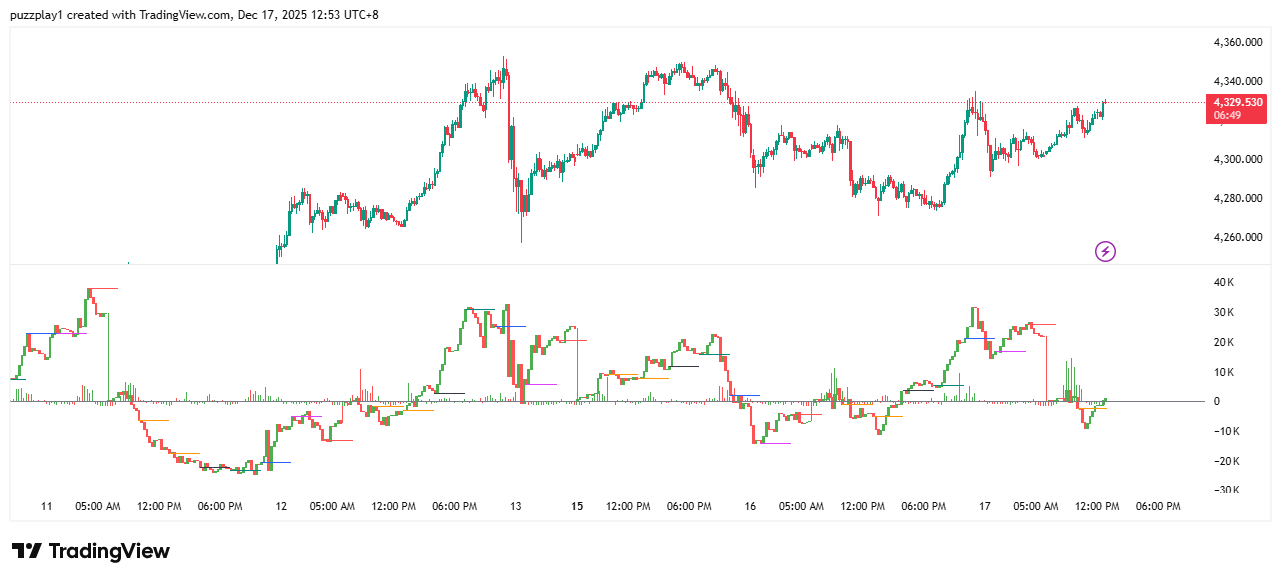